# Population growth case study

This notebook will explore the conditions that influence population growth. This will be the first notebook to leverage `pyevo` in conjunction with statistics to conduct an in-depth analysis of an emergent phenomena

Let's start with a simple simulation of a basic blob population living in a basic environment. These blobs will be okay at surviving and okay at reproducing, but will do nothing much else

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from helpers import determine_number_survivors_of_type
from environment import *
from blobs import *

%load_ext autoreload
%autoreload 2

In [2]:
basic_population = [BaseBlob() for x in range(25)]

e = BaseEnvironment()
e.spawn_population(basic_population)

In [3]:
print(e.population[0][0])

BaseBlob(s=0.5,r=0.5,m=0.5)


For all intensive purposes, these blobs are relatively boring. Let's see what happens if we leave them alone for 30 epochs

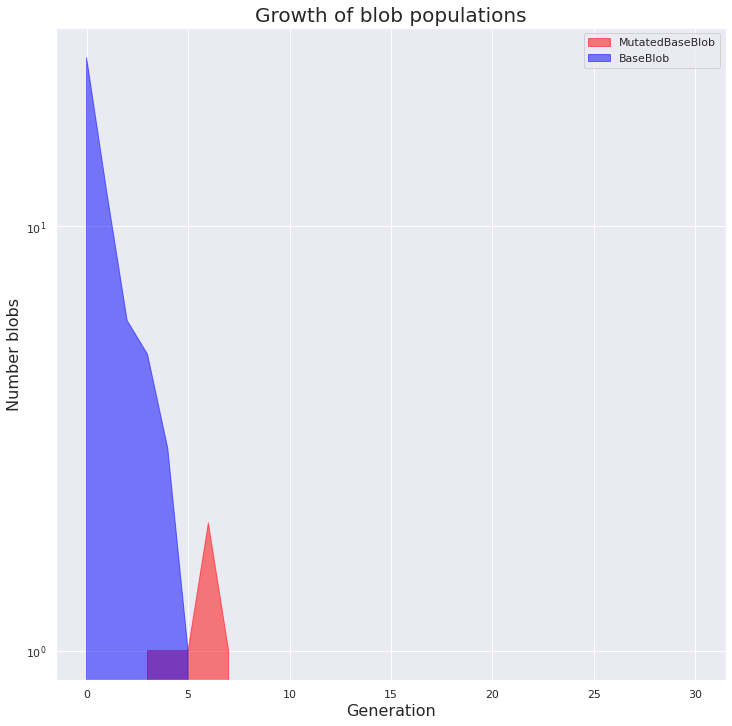

In [4]:
for i in range(30):
    e.interact()
e.plot_growth()

As expected, the population just dies off relatively quickly. This is because not enough blobs are reproducing to make up for the ones that are dying. This won't do, as we want our blobs to grow up healthy, strong, and produce many more generations of blobs

Let's tweak the survival attribute to make our next blob population sturdier and see what happens

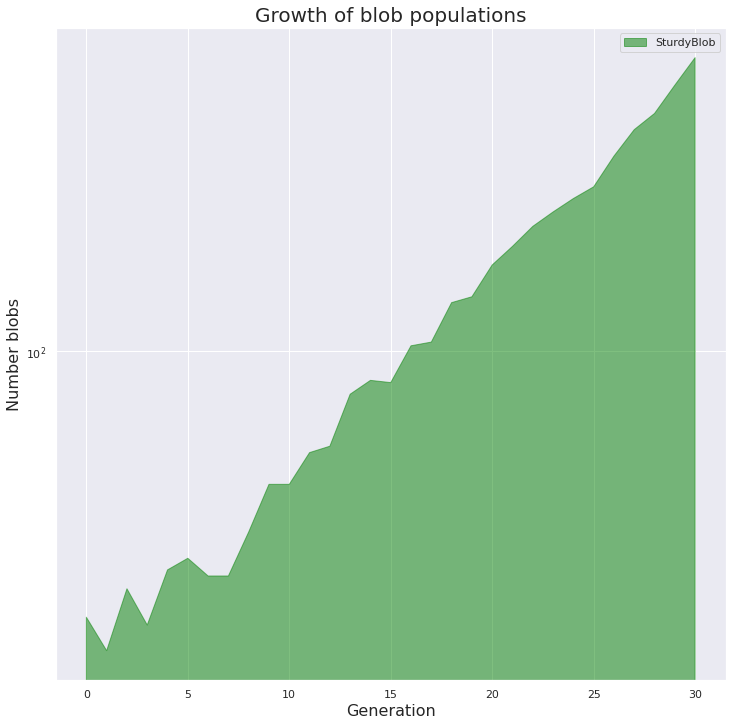

In [5]:
sturdier_population = [SturdyBlob() for x in range(25)]
    
f = BaseEnvironment()
f.spawn_population(sturdier_population)

for i in range(30):
    f.interact()
    
f.plot_growth()

Wow nice! By making this generation of blobs sturdier, more of the blobs were able to survive and reproduce at each epoch which meant growth over time

In general, the takeaway from this is that to determine whether a population grows or shrinks, a reasonable first-approximation is simply to look at the ratio between death and reproduction. Populations in which `reproduction rate > death rate` will grow, whereas the opposite will shrink.

We can represent this hypothesis ($1$) mathematically where, in the absence of outside forces, populations will survive if and only if

$$\frac{\textrm{reproduction prob}}{1 - \textrm{survival prob}} > 1$$

Our earlier population of `BasebBlob`s had `(s=0.5, r=0.5)` and thus $\frac{0.5}{1 - 0.5} \ngtr 1 \textrm{, population dies}$

Whereas the population of `SturdyBlob`s had `(s=0.8, r=0.5)` and thus $\frac{0.8}{1 - 0.5} > 1 \textrm{, population grows}$

If this is all correct, then we should expect that on average, any population of blobs with any `(s>r, r)` to grow over time. Let's see whether our simulation results agree with this

## Statistical modeling via Monte carlo

In an ideal world, we would simulate this $N >>1$ times across enough `(s, r)` conditions that we could get an accurate representation of how good of a hypothesis ($1$) is. In practice, this requires a high amount of computational resources

As an alternative, we can run a [Monte Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method) across many different `(s, r)` conditions as a way of approximating the distribution. Let's walk through this together

In [6]:
import scipy.stats

We will be using a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to compare the distributions of survival across different `(s, r)` pairings. Binomial distributions operate on successive [Bernouilli trials](https://en.wikipedia.org/wiki/Bernoulli_trial) wherein each "trial" returns a boolean. 

In short, this means that for each `(s, r)` pairing, we will generate a binomial distribution based on a threshold of whether the population has been deemed growing or dying. The higher the number of simulations per pairing, the more accurate our distribution will be

We'll be using `scipy.stats.norm.rvs` to create sample binomial distribution where the %survived is set by `loc`, the width of the distribution is set by `scale`, and the number of simulations is set by `size`. The scale distribution For example, consider these distributions

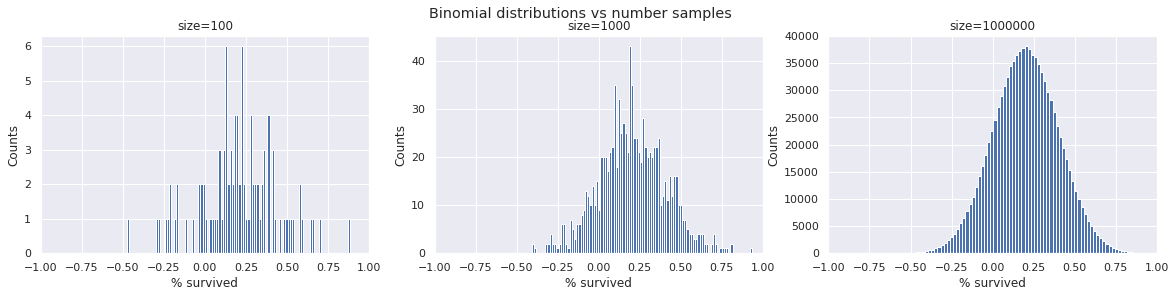

In [7]:
#Create an example dataset distribution
survived_perc = 0.2

a = scipy.stats.norm.rvs(loc=survived_perc, scale=0.2, size=100)
b = scipy.stats.norm.rvs(loc=survived_perc, scale=0.2, size=1000)
c = scipy.stats.norm.rvs(loc=survived_perc, scale=0.2, size=1000000)

fig, axes = plt.subplots(1, 3, figsize=(20,4))
axes[0].hist(a, bins=100)
axes[1].hist(b, bins=100)
axes[2].hist(c, bins=100)

axes[0].set_title("size=100")
axes[1].set_title("size=1000")
axes[2].set_title("size=1000000")

for ax in axes:
    ax.set_xlabel('% survived')
    ax.set_ylabel('Counts')
    ax.set_xlim([-1, 1])
    
plt.suptitle('Binomial distributions vs number samples')
plt.show()

As we can see, the higher our number of samples/simulations, the more representative our distribution is of the underlying data

In order to compare populations, we can analyze the [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) based off the difference in population means. For example, let's see if we can confidently say two distributions with two different survival probabilities can be said to be different

(-2.0, 2.0)

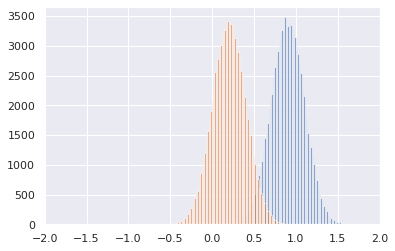

In [8]:
#Create two dummy populations
a = scipy.stats.norm.rvs(loc=0.9, scale=0.2, size=100000)
b = scipy.stats.norm.rvs(loc=0.2, scale=0.2, size=100000)
_ = plt.hist(a, alpha=0.6, bins=100)
_ = plt.hist(b, alpha=0.6, bins=100)
plt.xlim([-2, 2])

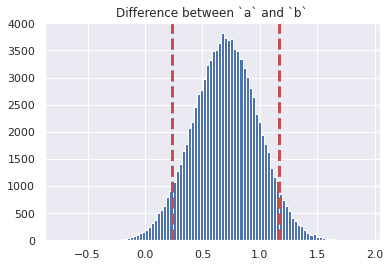

Lower confidence interval (LCI): 0.2343917404484142
Upper confidence interval (UCI): 1.1634450213913825
LCI > 0: True


In [9]:
#Plot difference in means of the populations
diff = a - b
_ = plt.hist(diff, bins=100)
lci, uci = np.quantile(diff, [0.05, 1-0.05]) #lower confidence interval and upper confidence interval
plt.axvline(lci, lw=3, ls="--", c='r')
plt.axvline(uci, lw=3, ls="--", c='r')
plt.title(f"Difference between `a` and `b`")
plt.show()
print(f"Lower confidence interval (LCI): {lci}")
print(f"Upper confidence interval (UCI): {uci}")
print(f"LCI > 0: {lci > 0}")

Since the 95% confidence intervals doesn't include 0, we can be fairly confident that these dummy populations `a` and `b` are different

## Setting up the simulation

Now that we have the basic statistics explained, we can start setting up the parameters of our simulation. What we intend to do is to study the impacts of `(s, r)` on population growth by using a monte carlo simulation to bootstrap the underlying distribution

In [10]:
#Setup matrix of (s, r) pairings. NOTE - intentionally explicitly defining array to avoid floating point inaccuracies
s_values = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
r_values = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

s_r_pairings = [(s, r) for s in s_values for r in r_values] + [(r, s) for s in s_values for r in r_values]
s_r_pairings = list(set(s_r_pairings)) #remove duplicate pairings
s_r_pairings.sort(key=lambda x: x[0])
s_r_pairings.sort(key=lambda x: x[1])
print(s_r_pairings[:10])

[(0.0, 0.0), (0.2, 0.0), (0.4, 0.0), (0.6, 0.0), (0.8, 0.0), (1.0, 0.0), (0.0, 0.2), (0.2, 0.2), (0.4, 0.2), (0.6, 0.2)]


In [11]:
#Setup conditions of the simulation
n_starting_blobs = 10
n_epochs = 5
n_simulations_per_pairing = 1000
survival_threshold = 5 #If the N remaining blobs after n_epochs is greater than this threshold, consider population stable. If below, consider it extinct

pairing_success = {pair: [] for pair in s_r_pairings}

For each `(s, r)` pair, we're going to create a population of `n_starting_blobs` `SimBlob`s with that attribute pairing. We will then let these blobs interact for `n_epochs` epochs, and then we'll evaluate whether the population is growing or dying at this point based off whether there are more than the `survival_threshold` remaining. We will do this `n_simulations_per_pairing` for each pair

In [12]:
for pair in s_r_pairings:
    # Init a new class for each pairing
    class SimBlob(BaseBlob):
        """Blob for testing variable (s, r) pairings"""
        def __init__(self):
            super().__init__()
            self.name = 'SimBlob'
            self.repr_class = SimBlob
            self.survival_prob = pair[0]
            self.reproduction_prob = pair[1]
            self.mutation_prob = 0.0
    
    pop = [SimBlob() for y in range(n_starting_blobs)]
    
    for simulation in range(n_simulations_per_pairing):
        e = BaseEnvironment()
        e.spawn_population(pop)
        for epoch in range(n_epochs):
            e.interact()
        pair_survived = (determine_number_survivors_of_type('SimBlob', e.population) >= survival_threshold)
        pairing_success[pair].append(pair_survived)

That's our simulation! Let's do a sanity check

In [13]:
print(pairing_success[(0.0, 0.0)][:10]) #These should all die since none of them survive or reproduce
print(pairing_success[(1.0, 0.0)][:10]) #These should all be alive since all survive and reproduce

[False, False, False, False, False, False, False, False, False, False]
[True, True, True, True, True, True, True, True, True, True]


## Analyzing results
Now let's plot the data. What we're expecting to see if that for `(s, r)` pairings where `(s>r, r)`, the population should be growing.

In [14]:
#Get % populations simulated that are stable for each (s, r) pair
stable_populations  = {pair: (pairing_success[pair].count(True)/n_simulations_per_pairing) for pair in pairing_success}

#For each pairing, create binomial distribution centered around number successes
pair_binomials = {pair: scipy.stats.norm.rvs(loc=stable_populations[pair], scale=0.2, size=100000) for pair in pairing_success}

In [15]:
def legend_without_duplicate_labels(ax):
    """
    Function to plot ax w/o any duplicate labels
    https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib/19386045#19386045
    """
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper right')

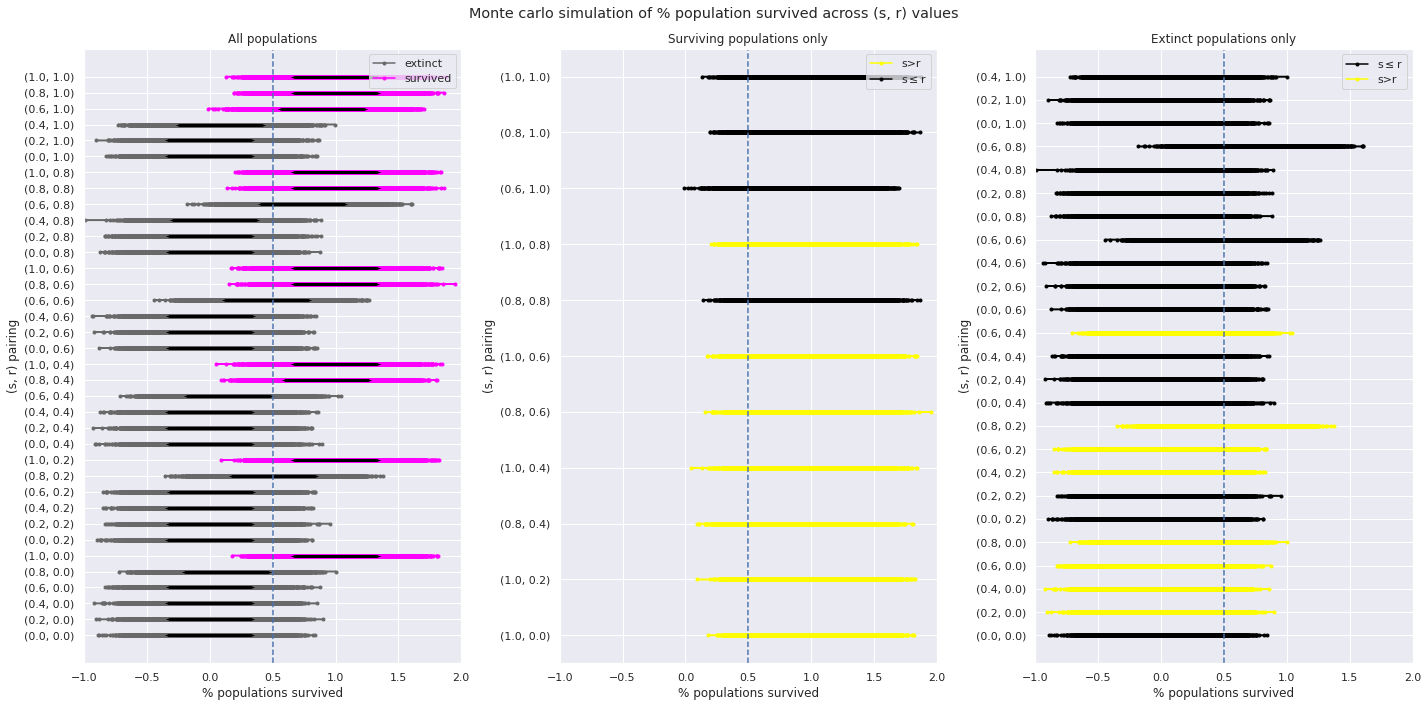

In [16]:
#A lot of plotting here, specifics not important
growing_populations = {}
extinct_populations = {}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))

for pair in pair_binomials:
    dist = pair_binomials[pair]
    lci, uci = np.quantile(dist, [0.05, 0.95])
    if lci >= 0.5:
        c = 'magenta'
        label='survived'
        growing_populations[pair] = dist
    else:
        c = 'dimgrey'
        label='extinct'
        extinct_populations[pair] = dist
    axes[0].plot(dist, [str(pair)]*len(dist), c=c, label=label, marker='.')
    axes[0].plot([lci, uci], [str(pair)]*2, linewidth=3, c='black', marker="_")

for pop in growing_populations:
    dist = growing_populations[pop]
    if pop[0] > pop[1]:
        c = 'yellow'
        label='s>r'
    else:
        c = 'black'
        label = r's$\leq$r'
    axes[1].plot(dist, [str(pop)]*len(dist), c=c, label=label, marker='.')
    
for pop in extinct_populations:
    dist = extinct_populations[pop]
    if pop[0] > pop[1]:
        c = 'yellow'
        label='s>r'
    else:
        c = 'black'
        label = r's$\leq$r'
    axes[2].plot(dist, [str(pop)]*len(dist), c=c, label=label, marker='.')

axes[0].set_title('All populations')
axes[1].set_title('Surviving populations only')
axes[2].set_title('Extinct populations only')
    
for ax in axes:
    ax.set_xlabel('% populations survived')
    ax.set_ylabel('(s, r) pairing')
    ax.axvline(0.5, ls='--')
    ax.set_xlim([-1, 2])
    legend_without_duplicate_labels(ax)
    
fig.suptitle('Monte carlo simulation of % population survived across (s, r) values')
plt.tight_layout()
plt.show()

This is pretty interesting! In the <i>left</i>, we show in magenta which populations survived based off `>0.5` populations in the simulation being above the `survival_threshold` value. This shows that most pairings do not survive, with only 11/36 pairing populations surviving.

In contrast to what was predicted with ($1$) however, it looks like while most of the surviving populations (<i>middle</i>) tend to have `(s>r, r)` pairings, some with `(s<=r, r)` can also survive and grow. Additionally, this condition does not guarantee survival as many with this pairing end up going extinct in the end (<i>right</i>).

Let's look at a heatmap of population survival vs the attributes to see how we can amend ($1$) to better represent these findings

In [17]:
heatmap_coords = []
for s in s_values[::-1]:
    s_list = []
    for r in r_values:
        s_list.append(stable_populations[(s, r)])
    heatmap_coords.append(s_list)

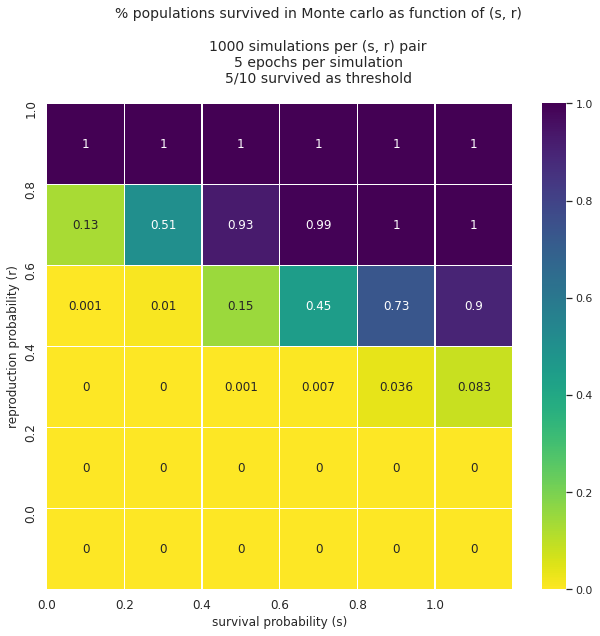

In [18]:
hm_im = np.array(heatmap_coords)

n_starting_blobs = 10
n_epochs = 5
n_simulations_per_pairing = 1000

fig, ax = plt.subplots(figsize=(9,9))
ax = sns.heatmap(hm_im, annot=True, linewidth=0.5, cmap="viridis_r")

ax.set_xticks(np.arange(len(s_values)))
ax.set_xticklabels(s_values)
ax.set_xlabel('survival probability (s)')

ax.set_yticks(np.arange(len(r_values)))
ax.set_yticklabels(r_values[::-1])
ax.set_ylabel('reproduction probability (r)')
ax.grid(False)

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)


fig.suptitle(f'% populations survived in Monte carlo as function of (s, r)\n\n'
             f'{n_simulations_per_pairing} simulations per (s, r) pair\n'
             f'{n_epochs} epochs per simulation\n'
             f'{survival_threshold}/{n_starting_blobs} survived as threshold',
            fontsize=14)
plt.tight_layout()
plt.show()

Interesting! It looks like there's a definite trend towards high `(s, r)` values even if the `(s>r, r)` condition isn't met. This, combined with our previous finding that most, but not all, survived populations featured this ratio, suggests that this condition is favorable towards population survival, but both high `s` and `r` values can be sufficient to bias towards survival. In fact, it looks like `r` is a stronger contributor than `s` as low reproduction probabilities, regardless of survival probabilities, almost guarantee extinction

While our hypothesis turned out to be inaccurate, we came out with even more findings!